In [26]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
import CRTS_paper_modules as mod
import datetime
from matplotlib import rcParams
from scipy.optimize import curve_fit
from collections import OrderedDict

import sys
sys.path.insert(0, '../../SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF

** What happens here ** 

I apply correction factors per magnitude bin,  and plot the resulting SF in the quasar restframe, to make Fig. 5

I use a different fc for each magnitude range, as derived in E_Fig3_histogram  

    mag     | fc 
    17-18   | 0.8897
    18-18.5 | 1.1072
    18.5-19 | 1.2876
    
These numbers are derived from histograms of  the quantity $\chi$ calculated for Blue Stars, they are stored in data_products/Fig_3_data/2017-08-08/r_cut_minMag_maxMag_mean_fc.txt 

As we are reading the delta_t,  delta_m points, I correct the time-lag from observed frame to restframe by diving by 1+z .

This shifts all timescales to shorter times, and for this reason I had to modify calculating sigma, etc. for 200 bins, because I end up with some bins having 0 points (eg. bin 198 is empty for qso in mag range 18-18.5 )

We plot only $\log{(\Delta t)} < 3.2$, because we know that large values are bad (more points shift to shorter timescales in QSO restframe )  ( Zeljko's email November 30, 2016 ) 

In [44]:
# If we were using the full linear fit to the correction factor as a function of timescale...
# We are not, because the timescale-dependence is much smaller than the magnitude-dependence 
# Read in the linear correction coefficients....
file = '../data_products/Fig_3_data/2017-08-08/r_cut_minMag_maxMag_mean_fc.txt'
data = np.loadtxt(file, unpack=True)

Min_arr = np.array(data[0])
Max_arr = np.array(data[1])
fc_arr = np.array(data[2])


In [35]:
# Set a directory to save the results...
# the Fig_4_data directory 
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_5_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_5_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')

# the appropriate date subfolder... 
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)

print('Today we will save our Fig_5 files in %s'%outDir)

Today we will save our Fig_5 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/


## Read in xi, ei  for the objects in a given mag range ... 


## Calculate sigma approx and sigma full, applying correction factor to errors in each bin 

In [29]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_catalogs/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


Now the good thing is that fog F_Fig_4  we have already calculated the corrected SF for 200 bins for starsB and qso in observed frame.  So now only need to calculate corrected SF for QSO in restframe, and use the already obtained stellar results.  

In [30]:
def read_xi_ei_per_mag(Min=18,Max=18.5) : 
    # Set the magnitude range 
    objects_in_cut = {}
    mag = 'r'
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min,mag, Max))

    # use only qso 
    # use blue stars results from F_Fig_4,  since these are 
    # exactly the same stars, the only thing that changed are the 
    # quasars ... 
    good_ids_QSO, redshifts = mod.cut_qso(qso_cat=qso_cat, mMin = Min, 
                                         mMax=Max, mErrMax = 0.3, 
                                        cut_mag=mag, redshift='Yes')
    ## Read in the xi, ei for objects in that mag range ... 
    inDirQSO = '../data_products/sf_file_per_LC/qso/'
    out_dic = {}
    out_dic['qso'] = mod.faster_read_xi_ei(inDirSF = inDirQSO,
                                           good_ids = good_ids_QSO ,redshifts=redshifts)
    return out_dic

  

In [31]:
def calculate_binned_stats(out_dic, obj='qso', Min=None, 
                           Max=None, fc=None, outDir=None): 
    nbins = 200 

    print('Today we will save our Fig_5 files in %s'%outDir)
    print('Calculating SF for objects in magnitude bin %.2f - %.2f'%(Min,Max))
    # store the bin count...
    binned_dict = {}

    # Loop over objects in the dictionary  
    print('\n For obj = %s'% obj)
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[obj]['xi']
    tau =  out_dic[obj]['tau'] 
    e_ij = fc*out_dic[obj]['ei']  # apply the correction factor 


    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau   = binned_tau[0]   #len(mean_tau) = 200
    bin_number = binned_tau[2]   #len(bin_number) = len(tau)

    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))
    print('\n We have %d bins that are not empty'%np.sum(non_empty_bins))
    #  np.sum(non_empty_bins)  == len(np.unique(bin_number)).  
    # because the number of non-empty bins, is equal to the number of unique 
    # bins that are populated 

    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]   # len(bin_count) = 200

    # reassign number of points in a bin and  tau position 
    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]

    ####  Panel 1 : Standard Deviation 
    rms_std = lambda x : np.std(x)
    bin_stdev = binned_statistic(tau, m_ij, statistic = rms_std, 
                                 bins=nbins)[0][non_empty_bins]  

    ##### Panel 2  : Gaussian rms  
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    # Loop over all bins  calculating approximate mu and sigma 
    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(len(mean_tau))
    mu_bins['approx'] = np.zeros(len(mean_tau))
    sig_bins['full'] = np.zeros(len(mean_tau))
    mu_bins['full'] = np.zeros(len(mean_tau))
    c = 0 
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        #fc_bin = binned_fc[c]  # because binned_fc is made of mean_tau, and eg if 
            # bin 198 is empty,  mean_tau has length of 199,  and binned_fc for 
        ei = e_ij[bin_number == N]

        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)

        sig_bins['approx'][c] = sig_approx
        sig_bins['full'][c] = sig_full

        mu_bins['approx'][c] = mu_approx
        mu_bins['full'][c] = mu_full 
        c+=1 
    # Save the results of calculation  : Panel 1,2,3,4 
    fname = outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_rest.txt'


    save_data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], 
                            bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount '
    np.savetxt(fname, save_data, fmt = '%s', delimiter = ' ' , header=header )
    print('Results saved as %s'%fname)
    print('Done with calculating panel data ')    

In [32]:
#  Calculate restframe - corrected binned SF 
# for QSO only 

for Min, Max, fc in zip(Min_arr, Max_arr, fc_arr):
    # first read in the redshift- corrected QSO 
    # delta_mag, delta_time files 
    out_dic = read_xi_ei_per_mag()
    
    # then calculate the binned stats...
    calculate_binned_stats(out_dic, obj='qso', Min=Min, 
                           Max=Max, fc=fc, outDir=outDir)
    


Using now only lightcurves with SDSS  18.000000< r < 18.500000

 Returning only QSO with  an SDSS counterpart within 2.000000 arcsec

 These cuts reduced the number of qso  in the sample from 7601 to 333

  Also returning quasar redshifts...

Reading in tau,xi,ei  for 333 objects

Using structure function master files from ../data_products/sf_file_per_LC/qso/
Applying redshift correction tau_rest = tau_obs / (1+z)
[######### ] 99.10%
Finished reading all master files for the selected objects ...
Today we will save our Fig_5 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/
Calculating SF for objects in magnitude bin 17.000000 - 18.000000

 For obj = qso

 We have 199 bins that are not empty
 --- Calculating mu, sigma for bin 1
 --- Calculating mu, sigma for bin 2
 --- Calculating mu, sigma for bin 3
 --- Calculating mu, sigma for bin 4
 --- Calculating mu, sigma for bin 5
 --- Calculating mu, sigma for bin 6
 --- Calculating mu, sigma for bin 7
 --- 

../../SDSS_S82_FP_research/packages/variabilityFunctions.py:211: RuntimeWarning: divide by zero encountered in true_divide
  p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum()


[######### ] 99.10%
Finished reading all master files for the selected objects ...
Today we will save our Fig_5 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/
Calculating SF for objects in magnitude bin 18.000000 - 18.500000

 For obj = qso

 We have 199 bins that are not empty
 --- Calculating mu, sigma for bin 1
 --- Calculating mu, sigma for bin 2
 --- Calculating mu, sigma for bin 3
 --- Calculating mu, sigma for bin 4
 --- Calculating mu, sigma for bin 5
 --- Calculating mu, sigma for bin 6
 --- Calculating mu, sigma for bin 7
 --- Calculating mu, sigma for bin 8
 --- Calculating mu, sigma for bin 9
 --- Calculating mu, sigma for bin 10
 --- Calculating mu, sigma for bin 11
 --- Calculating mu, sigma for bin 12
 --- Calculating mu, sigma for bin 13
 --- Calculating mu, sigma for bin 14
 --- Calculating mu, sigma for bin 15
 --- Calculating mu, sigma for bin 16
 --- Calculating mu, sigma for bin 17
 --- Calculating mu, sigma for bin 18
 --- Cal

../../SDSS_S82_FP_research/packages/variabilityFunctions.py:211: RuntimeWarning: divide by zero encountered in true_divide
  p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum()


[######### ] 99.10%
Finished reading all master files for the selected objects ...
Today we will save our Fig_5 files in /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/
Calculating SF for objects in magnitude bin 18.500000 - 19.000000

 For obj = qso

 We have 199 bins that are not empty
 --- Calculating mu, sigma for bin 1
 --- Calculating mu, sigma for bin 2
 --- Calculating mu, sigma for bin 3
 --- Calculating mu, sigma for bin 4
 --- Calculating mu, sigma for bin 5
 --- Calculating mu, sigma for bin 6
 --- Calculating mu, sigma for bin 7
 --- Calculating mu, sigma for bin 8
 --- Calculating mu, sigma for bin 9
 --- Calculating mu, sigma for bin 10
 --- Calculating mu, sigma for bin 11
 --- Calculating mu, sigma for bin 12
 --- Calculating mu, sigma for bin 13
 --- Calculating mu, sigma for bin 14
 --- Calculating mu, sigma for bin 15
 --- Calculating mu, sigma for bin 16
 --- Calculating mu, sigma for bin 17
 --- Calculating mu, sigma for bin 18
 --- Cal

../../SDSS_S82_FP_research/packages/variabilityFunctions.py:211: RuntimeWarning: divide by zero encountered in true_divide
  p_sigma /= (sigma[1] - sigma[0]) * p_sigma.sum()


In [43]:
str(Min_arr[0]).zfill()

'017'

## Read in plotting data from  saveFiles

If you have  already calculated statistics for each bin,  can simply read the file, and proceed to plotting, skipping steps above 

In [45]:
import numpy as np
from scipy.optimize import curve_fit
from collections import OrderedDict

# the directory with results previously calculated ... 
#outDir = '/Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-01-11/'

plot_data = OrderedDict()

for mag in Min_arr:
    plot_data[mag] = OrderedDict()
    
for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for obj in ['qso','starsB']:
        plot_data[Min][obj] = {}
        if obj is 'qso':
            fname =  outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_rest.txt'
        else:
            fname =  outDir+ 'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
        print('Loading... %s'% fname )
        
        colnames = open(fname,'r').read().splitlines()[0][1:].split()
        d = np.genfromtxt(fname, dtype=float)
        
        for label, column in zip(colnames, d.T):
            plot_data[Min][obj][label] = column
        


Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_17.0-18.0_qso_rest.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_17.0-18.0_starsB.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_18.0-18.5_qso_rest.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_18.0-18.5_starsB.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_18.5-19.0_qso_rest.txt
Loading... /Users/chris/GradResearch/CRTS_PROJECT/data_products/Fig_5_data/2017-08-14/r_cut_18.5-19.0_starsB.txt


## Plot the data 

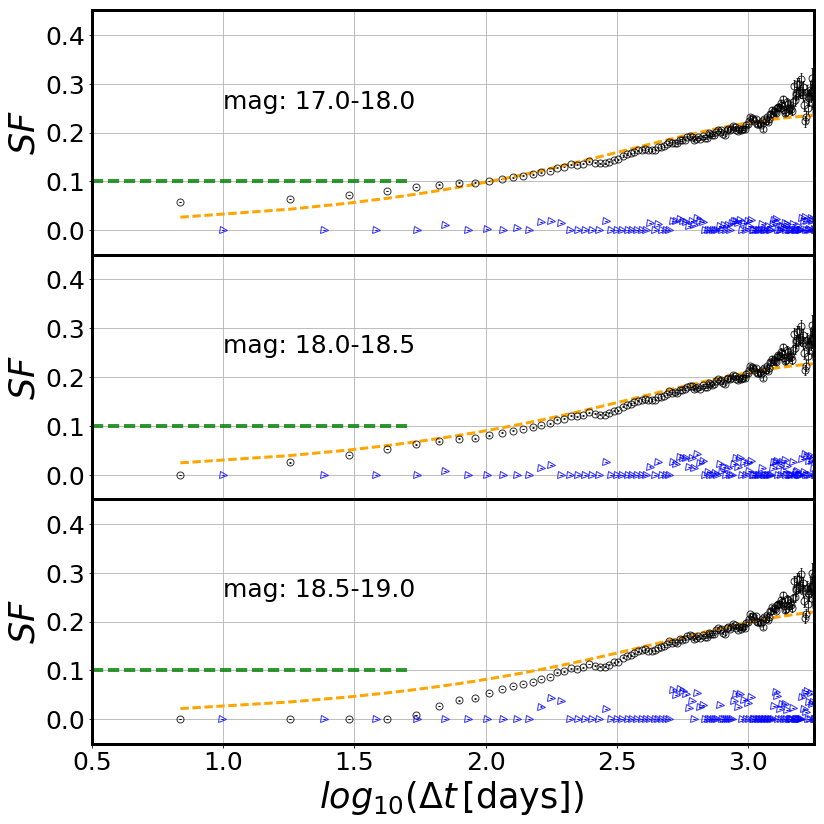

In [48]:
%matplotlib inline

def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf
        
rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25
rcParams.update({'figure.autolayout': False})


obj_arr = ['qso',  'starsB']
colors= {'qso':'black',  'starsB':'blue'}
markers = {'qso':'o',  'starsB': '>'}


# choose sigma calculation type to be displayed...
calc = 'Approx'
    
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 7 #7
p_al   = 0.5 

# y limits for SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.25
def plot_errorbar(ax, x,y,yerr, obj, linestyle='None', markersize=p_size,
                 markerfacecolor='None',elinewidth=1, 
                  markeredgewidth=1, capsize=1, alpha=0.8, colors=colors, 
                  markers=markers ):
    ''' A quick convenience function to use the 
    same default markers, etc. for all plots
    '''
    ax.errorbar(x,y,yerr,linestyle=linestyle, c = colors[obj],
                marker=markers[obj],  markersize=p_size, markeredgecolor=colors[obj],
                markerfacecolor='None', markeredgewidth=1,  elinewidth=1, capsize=1, 
                alpha=0.8)
    
fig,ax = plt.subplots(3,1, figsize=(12,12), sharex=True)

for i in range(len(Min_arr)):
    Min = Min_arr[i]
    Max = Max_arr[i]
    for j in range(len(obj_arr)):
        obj = obj_arr[j]
        
        plot = plot_data[Min][obj]
        
        x = np.log10(plot['meanTau'])
        y = plot['sigma'+calc]
        yerr = plot['sigma'+calc]* 1.06 / np.sqrt(plot['binCount'])
        plot_errorbar(ax[i], x,y,yerr, obj)
        
        if obj == 'qso' : 
            # Calculate the model DRW fit for QSO
            xdata = plot['meanTau']
            sf = plot['sigma'+calc]
            popt, pcov = curve_fit(model_sf, xdata, sf)
            y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 
            ax[i].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')


for i in range(len(Min_arr)) :
    ax[i].text(1.0, 0.25, 'mag: '+str(Min_arr[i])+'-'+str(Max_arr[i]) )
    ax[i].set_ylabel(r'$SF$')
    ax[i].set_ylim(bottom=y_bott, top=y_top)
    ax[i].set_xlim(left=x_left, right=x_right)
    ax[i].grid() 
    ax[i].hlines(y=0.1, xmin =0.5, xmax=1.7, color='green', lw = 4,
                 linestyle = '--' , alpha = 0.8  )

    ax[i].set_yticks([0,0.1,0.2,0.3,0.4])
    ax[i].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
    

ax[-1].set_xlabel(r'$log_{10} (\Delta {t} \, \mathrm{[days]})$ ') 
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig(outDir+'Fig_5_SF_QSO_starsB_rest.png')
plt.show()



### I can plot a histogram of counts, if needed to check anything... 

In [ ]:
%matplotlib inline 
import seaborn as sns
sns.set_context('talk')
fig,ax = plt.subplots(1,2, figsize=(12,6))
colors = {'qso':'red', 'starsB':'blue'}
#colors['qso'] = 'red'
for i in range(len(binned_dict.keys())):
    obj = binned_dict.keys()[i]
    hist = binned_dict[obj][0]
    bin_edges = binned_dict[obj][1]
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    ax[i].plot(bin_centres, hist, ls='steps', label = obj, color=colors[obj])
    ax[i].legend()
    ax[i].set_xlabel(r'$\Delta t$', fontsize=20)
    ax[i].set_ylabel('Bin count', fontsize=20)
plt.tight_layout()
plt.savefig(outDir+'r_cut'+'_'+str(Min)+'-'+str(Max)+'_'+'bin-count_rest.png')